In [ ]:
!pip install tqdm requests beautifulsoup4

In [143]:
import time
from time import sleep

import requests
from bs4 import BeautifulSoup
from tqdm import tqdm, trange

from collections import namedtuple
from dataclasses import dataclass

In [30]:
BASE_URL = "https://www.chitai-gorod.ru"
BEGIN_URL = f"{BASE_URL}/catalog/books/"

In [31]:
r = requests.get(BEGIN_URL)
soup = BeautifulSoup(r.text, 'lxml')

In [32]:
Genre = namedtuple("Genre", ["name", "href"])

### Определяем список жанров

In [33]:
genres_raw = soup.find_all("ul", {"class": "navigation navigation"})[1]
genres_raw = genres_raw.find_all("a", {"class": "navigation__link"})
genres_raw

[<a class="navigation__link" href="/catalog/books/khudozhestvennaya_literatura-9657/">Художественная литература</a>,
 <a class="navigation__link" href="/catalog/books/knigi_dlya_detey-9072/">Книги для детей</a>,
 <a class="navigation__link" href="/catalog/books/obrazovaniye-9405/">Образование</a>,
 <a class="navigation__link" href="/catalog/books/nauka_i_tekhnika-9170/">Наука и техника</a>,
 <a class="navigation__link" href="/catalog/books/obshchestvo-9304/">Общество</a>,
 <a class="navigation__link" href="/catalog/books/delovaya_literatura-8979/">Деловая литература</a>,
 <a class="navigation__link" href="/catalog/books/krasota_zdorovye_sport-9116/">Красота. Здоровье. Спорт</a>,
 <a class="navigation__link" href="/catalog/books/uvlecheniya-9564/">Увлечения</a>,
 <a class="navigation__link" href="/catalog/books/psikhologiya-9530/">Психология</a>,
 <a class="navigation__link" href="/catalog/books/ezoterika-9705/">Эзотерика</a>,
 <a class="navigation__link" href="/catalog/books/filosofiya

In [34]:
genres = [Genre(name=i.text, href=i['href']) for i in genres_raw if i.text]
genres

[Genre(name='Художественная литература', href='/catalog/books/khudozhestvennaya_literatura-9657/'),
 Genre(name='Книги для детей', href='/catalog/books/knigi_dlya_detey-9072/'),
 Genre(name='Образование', href='/catalog/books/obrazovaniye-9405/'),
 Genre(name='Наука и техника', href='/catalog/books/nauka_i_tekhnika-9170/'),
 Genre(name='Общество', href='/catalog/books/obshchestvo-9304/'),
 Genre(name='Деловая литература', href='/catalog/books/delovaya_literatura-8979/'),
 Genre(name='Красота. Здоровье. Спорт', href='/catalog/books/krasota_zdorovye_sport-9116/'),
 Genre(name='Увлечения', href='/catalog/books/uvlecheniya-9564/'),
 Genre(name='Психология', href='/catalog/books/psikhologiya-9530/'),
 Genre(name='Эзотерика', href='/catalog/books/ezoterika-9705/'),
 Genre(name='Философия и религия', href='/catalog/books/filosofiya_i_religiya-9645/'),
 Genre(name='Искусство', href='/catalog/books/iskusstvo-9035/'),
 Genre(name='Подарочные издания', href='/catalog/books/podarochnyye_izdaniya-9

In [269]:
# структура описания книги

@dataclass
class Book:
    title: str
    author: str
    genre: str
    annotation: str
    url: str
    publisher: str
    series: str
    year: int
    isbn: str
    pages: int
    height: float
    width: float
    thickness: float
    cover_type: str
    circulation: int # тираж
    weight: float
    age_restrictions: str
    price: int
    rating: float
    rating_count: int # количество оценок
    in_stock: bool

### Парсинг книг

Парсим отдельно книги по разным жанрам

In [270]:
# извлечение нужной информации со страницы книги
def parse_book(url: str, genre: str):
    resp = requests.get(f"{BASE_URL}/{url}")
    soup = BeautifulSoup(resp.text, "lxml")
    
    if title := soup.find("h1", {"class": "product__title js-analytic-product-title"}):
        title = title.text.strip()
    
    if author := soup.find("a", {"class": "link product__author"}):
        author = author.text.strip()
        
    if annotation := soup.find("div", {"itemprop": "description"}):
        annotation = annotation.text.strip()
    
    if publisher := soup.find("span", {"itemprop": "publisher"}):
        publisher = publisher.text
    
    if series := soup.find("span", {"itemprop": "genre"}):
        series = series.text
    else:
        series = None
        
    if year := soup.find("div", {"itemprop": "datePublished"}):
        year = int(year.text)
        
    if isbn := soup.find("span", {"itemprop": "isbn"}):
        isbn = isbn.text.strip()
    
    
    try:
        if pages := soup.find("div", {"itemprop": "numberOfPages"}):
            pages = int(pages.text.strip())
    except:
        pages = None
        
    if size := soup.find("div", text="Формат"):
        size = size.findNext("div").text.strip()
        height, width, thickness = (float(i) for i in size.split(" x "))
    else:
        height, width, thickness = (None, None, None)
    
    if cover_type := soup.find("div", text="Тип обложки"):
        cover_type = cover_type.findNext("div").text.strip()
    
    if circulation := soup.find("div", text="Тираж"):
        circulation = int(circulation.findNext("div").text.strip())
        
    if weight := soup.find("div", text="Вес, г"):
        weight = float(weight.findNext("div").text.strip())
    
    if age_restrictions := soup.find("div", text="Возрастные ограничения"):
        age_restrictions = age_restrictions.findNext("div").text.strip()
    
    
    if price := soup.find("div", {"class": "price"}):
        price = price.text.replace("₽", "")
    
    try:
        rating = float(soup.find("span", {"class": "js__rating_count"}).text)
        rating_count = int(soup.find("span", {"class": "star-rating__text js__star_rating_text"}).text.split()[0])
    except:
        rating = 0.0
        rating_count = 0
    
    if in_stock := soup.find("span", {"class": "quantity__text"}):
        in_stock = in_stock.text == "В наличии"
    else:
        in_stock = False
    
    book = Book(
        url=url,
        title=title,
        genre=genre,
        author=author,
        annotation=annotation,
        publisher=publisher,
        series=series,
        year=year,
        isbn=isbn,
        pages=pages,
        height=height,
        width=width,
        thickness=thickness,
        cover_type=cover_type,
        circulation=circulation,
        weight=weight,
        age_restrictions=age_restrictions,
        price=price,
        rating=rating,
        rating_count=rating_count,
        in_stock=in_stock
    )
    return book


# пасринг книг заданного жанра
def parse_genre(genre: Genre, page=1):
    print(f"\tПарсинг страницы {page}")
    
    r = requests.get(f"{BASE_URL}/{genre.href}/?page={page}")
    soup = BeautifulSoup(r.text, "lxml")
    books = soup.find_all("div", {"class": "product-card__info"})
    books_urls = [i.find("a", {"class": "product-card__link"})["href"] for i in books]
    
    # берем максиммум 50 первых страниц из списка книг
    num_of_pages = min(50, int(soup.find_all("a", {"class": "pagination-item"})[-2].text))
    
    
    for url in books_urls:
        book = parse_book(url, genre)
        yield book
    
    if page < num_of_pages:
        for book in parse_genre(genre=genre, page=page+1):
            yield book


In [267]:
books = []
for genre in genres:
    print(f"Парсинг жанра {genre.name}")
    for book in parse_genre(genre):
        books.append(book)

Парсинг жанра Художественная литература
	Парсинг страницы 1
	Парсинг страницы 2


KeyboardInterrupt: 

In [166]:
import pandas as pd

In [183]:
df = pd.DataFrame(books)
df

,title,author,genre,annotation,url,publisher,series,year,isbn,pages,...,width,thickness,cover_type,circulation,weight,age_restrictions,price,rating,rating_count,in_stock
0,Каменное сердце,К.Дж. Сэнсом,"(Художественная литература, /catalog/books/khu...",Лето 1545 года. Франция стягивает армаду своих...,/catalog/book/2915753/,Азбука,The Big Book,2022.0,978-5-389-21286-2,800.0,...,11.5,3.0,Мягкая глянцевая,5000.0,370.0,16+,267,5.0,1,True
1,Однажды ночью в августе,Виктория Хислоп,"(Художественная литература, /catalog/books/khu...","Спустя пятнадцать лет после того, как увидел с...",/catalog/book/2915752/,Азбука,The Big Book,2022.0,978-5-389-21284-8,384.0,...,11.5,1.5,Мягкая глянцевая,5000.0,180.0,16+,193,0.0,0,True
2,Стамбульский бастард,Элиф Шафак,"(Художественная литература, /catalog/books/khu...",Роман «Стамбульский бастард» представляет исто...,/catalog/book/2915751/,Азбука,The Big Book,2022.0,978-5-389-21285-5,448.0,...,11.5,1.7,Мягкая глянцевая,5000.0,210.0,16+,193,0.0,0,True
3,Сюзанна,Бузлуков П.,"(Художественная литература, /catalog/books/khu...","Пусть родилась я не поэтом,\r\n— Пусть торгашо...",/catalog/book/2915731/,Де''Либри,None,2022.0,978-5-4491-1387-0,664.0,...,15.3,4.0,Твердая глянцевая,NaN,920.0,16+,403,0.0,0,False
4,Мертвое царство,Андрианова А.,"(Художественная литература, /catalog/books/khu...","Ивель — падальщица, бунтующая дочь из обеспече...",/catalog/book/2915730/,Animedia Company,Сказания Арконы,2022.0,978-80-7499-465-4,350.0,...,15.3,2.0,Твердая глянцевая,NaN,470.0,18+,1324,5.0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17199,Маркетинг без бюджета (с автографом),Манн И.,"(Книги с автографом, /catalog/books/knigi_s_av...",Идея написать книгу о маркетинге (почти или со...,/catalog/book/2901460/,"Манн, Иванов и Фербер",None,2020.0,None,288.0,...,17.3,3.0,None,NaN,620.0,16+,None,3.5,2,False
17200,Гастро-книга: Пищеварение вдоль и поперек (с а...,Вялов С.,"(Книги с автографом, /catalog/books/knigi_s_av...",Перед вами не учебник для врачей и не инструкц...,/catalog/book/2901459/,АСТ,Достоверная медицина,2020.0,None,304.0,...,14.5,2.0,None,NaN,420.0,12+,725,3.5,4,False
17201,Карнавал лжи (с автографом),Сафонова Е.С.,"(Книги с автографом, /catalog/books/knigi_s_av...",Полгода. Всего полгода спокойной жизни — столь...,/catalog/book/2901455/,Эксмо,None,2022.0,None,512.0,...,14.9,2.8,None,NaN,510.0,16+,625,5.0,3,False
17202,Когда завтра настанет вновь (с автографом),Сафонова Е.С.,"(Книги с автографом, /catalog/books/knigi_s_av...","В мире, где магия давно стала обыденностью и и...",/catalog/book/2901454/,Эксмо,None,2021.0,None,544.0,...,13.1,2.6,None,NaN,450.0,16+,575,5.0,3,False


In [194]:
df['genre_name'] = df['genre'].apply(lambda x: x[0])
df['genre_url'] = df['genre'].apply(lambda x: x[1])

df.drop(["genre"], axis=1, inplace=True)

In [189]:
df['price'] = pd.to_numeric(df['price'])

In [196]:
df.to_csv("ch_books.csv", index=False)

In [197]:
df = pd.read_csv("ch_books.csv")
df.head()

,title,author,annotation,url,publisher,series,year,isbn,pages,height,...,cover_type,circulation,weight,age_restrictions,price,rating,rating_count,in_stock,genre_name,genre_url
0,Каменное сердце,К.Дж. Сэнсом,Лето 1545 года. Франция стягивает армаду своих...,/catalog/book/2915753/,Азбука,The Big Book,2022.0,978-5-389-21286-2,800.0,18.0,...,Мягкая глянцевая,5000.0,370.0,16+,267.0,5.0,1,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/
1,Однажды ночью в августе,Виктория Хислоп,"Спустя пятнадцать лет после того, как увидел с...",/catalog/book/2915752/,Азбука,The Big Book,2022.0,978-5-389-21284-8,384.0,18.0,...,Мягкая глянцевая,5000.0,180.0,16+,193.0,0.0,0,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/
2,Стамбульский бастард,Элиф Шафак,Роман «Стамбульский бастард» представляет исто...,/catalog/book/2915751/,Азбука,The Big Book,2022.0,978-5-389-21285-5,448.0,18.0,...,Мягкая глянцевая,5000.0,210.0,16+,193.0,0.0,0,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/
3,Сюзанна,Бузлуков П.,"Пусть родилась я не поэтом,\r\n— Пусть торгашо...",/catalog/book/2915731/,Де''Либри,NaN,2022.0,978-5-4491-1387-0,664.0,21.7,...,Твердая глянцевая,NaN,920.0,16+,403.0,0.0,0,False,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/
4,Мертвое царство,Андрианова А.,"Ивель — падальщица, бунтующая дочь из обеспече...",/catalog/book/2915730/,Animedia Company,Сказания Арконы,2022.0,978-80-7499-465-4,350.0,21.7,...,Твердая глянцевая,NaN,470.0,18+,1324.0,5.0,1,True,Художественная литература,/catalog/books/khudozhestvennaya_literatura-9657/


# Исследование данных

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Выбросы

> Книга изданная в 3000 году!

In [234]:
df[df['year'] == df['year'].max()]

,title,author,annotation,url,publisher,series,year,isbn,pages,height,...,cover_type,circulation,weight,age_restrictions,price,rating,rating_count,in_stock,genre_name,genre_url
2342,Первоклассные смешинки,Ирина Гурина,Жизнь первоклассника Дениса наполнена забавным...,/catalog/book/2903096/,Феникс-Премьер,Школа по приколу,3000.0,978-5-222-37637-9,111.0,23.5,...,Твердая бумажная,NaN,350.0,0+,730.0,0.0,0,True,Книги для детей,/catalog/books/knigi_dlya_detey-9072/


Удалим все книги, "вышедшие" после 2022 года.

In [244]:
df = df[df['year'] <= 2022]

> Самая тяжелая книга весит 616 кг.? Опять ошибка

In [245]:
df[df['weight'] == df['weight'].max()][['title', 'weight']]

,title,weight
12338,Финляндская Православная Церковь в 1957-1988 г...,616000.0


In [246]:
df = df[df['weight'] != df['weight'].max()]

### Самые "дорогие" жанры

Подарочные издания, как и ожидается, входит в топ самых дорогих категорий товаров  
Образование и книги для детей - самые дешевые

In [247]:
df.groupby("genre_name")['price'].mean().sort_values(ascending=False)

genre_name
Подарочные издания             4964.091137
Эзотерика                      1337.004181
Наука и техника                1318.661358
Искусство                      1149.658027
Деловая литература             1051.949875
Общество                        957.904641
Увлечения                       946.407065
Книги на иностранных языках     922.570117
Психология                      846.625105
Философия и религия             810.966499
Книги с автографом              801.431734
Красота. Здоровье. Спорт        776.757322
Художественная литература       714.461153
Книги для детей                 462.654971
Образование                     404.204766
Name: price, dtype: float64

In [248]:
df.groupby('author').size().sort_values(ascending=False)

author
Горохова Ю. (ред.)                                                                                      38
Всеволод Костров                                                                                        30
В.В. Кузнецова                                                                                          29
Донцова Д.                                                                                              29
Фасхутдинов Р. (ред.)                                                                                   26
                                                                                                        ..
Игорь Долбышев                                                                                           1
Игорь Кожевников                                                                                         1
Игорь Лисов                                                                                              1
Абдуллаева Ольга Баходыровна, 

In [249]:
df.groupby('publisher').size().sort_values(ascending=False)

publisher
АСТ                        1844
Эксмо                      1478
Бомбора                     574
Лань                        302
Проспект                    278
                           ... 
Аверсэв                       1
Авиалогистика                 1
Аврора (СПб.)                 1
МТО Инфо                      1
Издатель Цимберов Р. М.       1
Length: 1189, dtype: int64

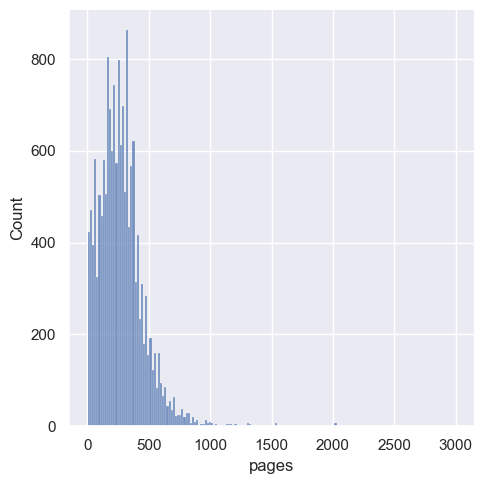

In [261]:
sns.displot(df['pages'])

Пользователи магазина "Читай-город" очень охотно ставят книгам максимальную оценку

<AxesSubplot:xlabel='rating', ylabel='Count'>

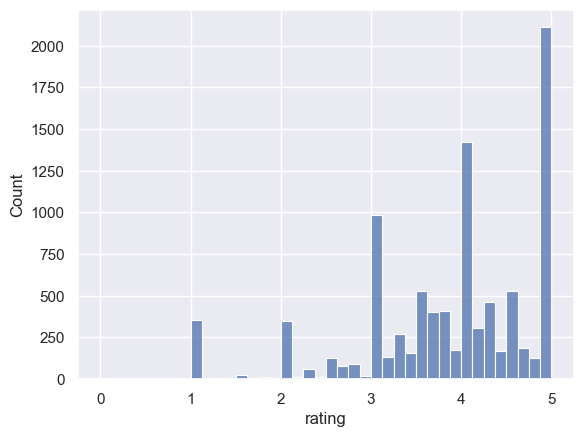

In [251]:
sns.histplot(df[df['rating_count'] != 0]['rating'])

> Ожидаемо, цена книги зависит от ее веса и количества страниц

<AxesSubplot:xlabel='weight', ylabel='price'>

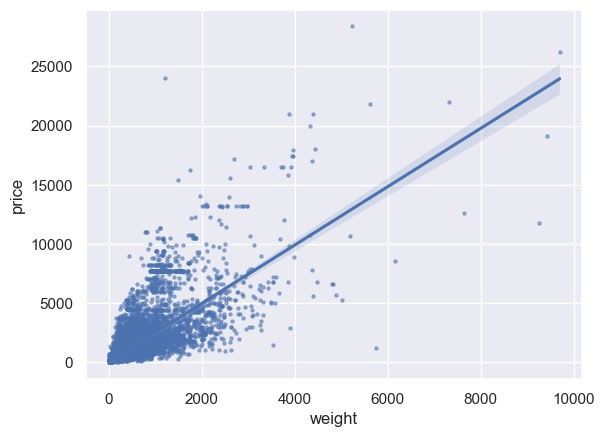

In [260]:
sns.regplot(data=df, x='weight', y='price', scatter_kws={'s': 5, 'alpha': 0.5})

<AxesSubplot:xlabel='pages', ylabel='price'>

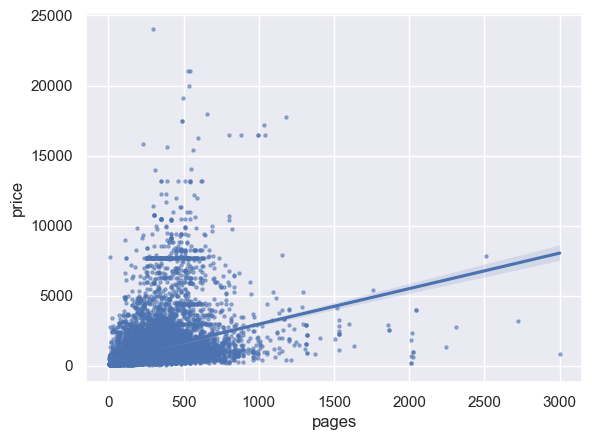

In [268]:
sns.regplot(data=df, x='pages', y='price', scatter_kws={'s': 5, 'alpha': 0.5})

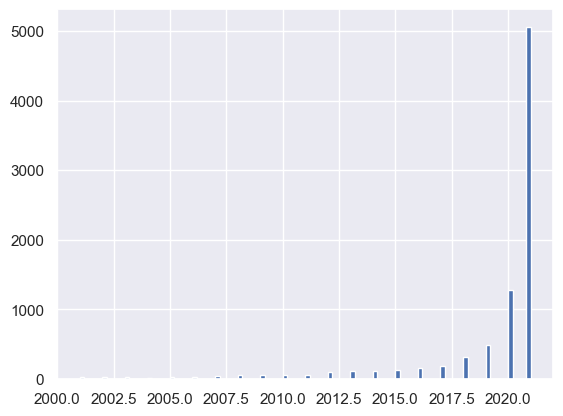

In [237]:
plt.hist(df[(df['year'] < 2022) & (df['year'] > 2000)]['year'], bins=100);